In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Define target attribute
attribute = 'sleeve_length'

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

### Load in Latents and Boundaries

In [5]:
input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/"
boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/"

In [6]:
# Load in Metadata
df = pd.read_csv(f"{input_base_dir}subset_metadata_{attribute}.csv")

# Load in Latents
latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

### Load in SG2Ada Generator

In [7]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

### Experiments with one single boundary

In [8]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [9]:
def get_interpolations(latent_code, boundary, start_distance, end_distance, steps, dims_to_change):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)


    for dim in dims_to_change:
        for i in range(steps):
            latent_code[i, dim, :] = latent_code[i, dim, :] + linspace[i] * boundary

    return latent_code

In [10]:
# Load in boundaries
dim = 0

boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}_{attribute}.npy")
boundary = torch.tensor(boundary)

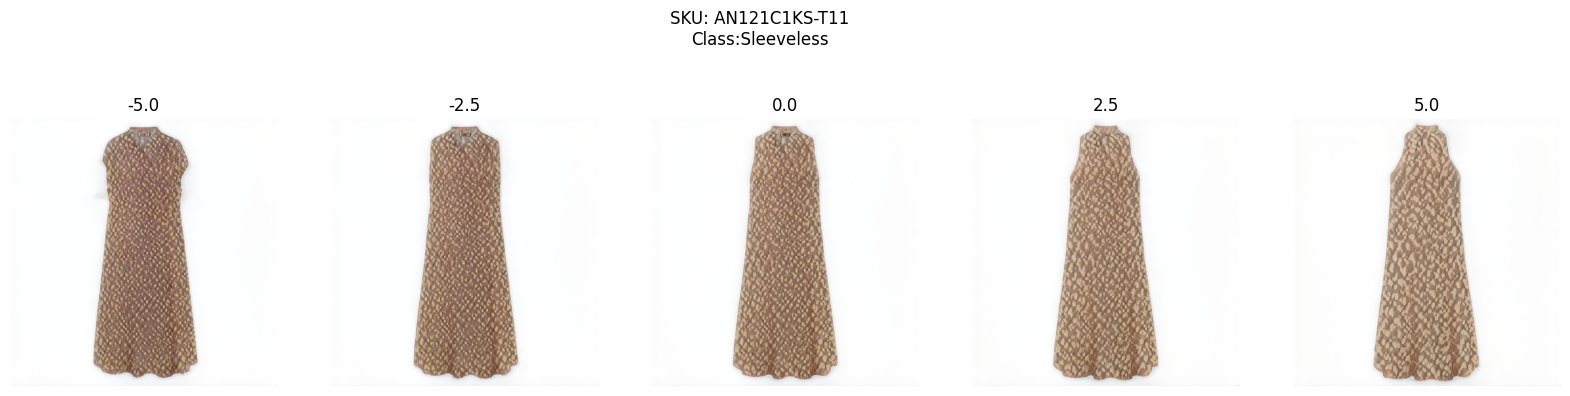

In [11]:
start_distance = -5
end_distance = 5
steps = 5

dims_to_change = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


# Sample one latent
sample = df.sample(1)
latent_code = latents[sample.sku.item()]

interpolations = get_interpolations(latent_code, boundary, start_distance, end_distance, steps, dims_to_change)

imgs = [generate_from_latent(interpolations[i, :, :].unsqueeze(0)) for i in range(steps)]
fig, ax = plt.subplots(1, steps, figsize=(20, 5))
ax = ax.ravel()
for i in range(steps):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
    ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")

fig.suptitle(f"SKU: {sample.sku.item()}\nClass:{sample[attribute].item()}")
plt.show()

### Experiments with all boundaries

In [12]:
def get_interpolations_multiple(latent_code, start_distance, end_distance, steps, dims_to_change):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)


    for dim in dims_to_change:
        boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}_{attribute}.npy")
        boundary = torch.tensor(boundary)
        for i in range(steps):
            latent_code[i, dim, :] = latent_code[i, dim, :] + linspace[i] * boundary
    
    return latent_code

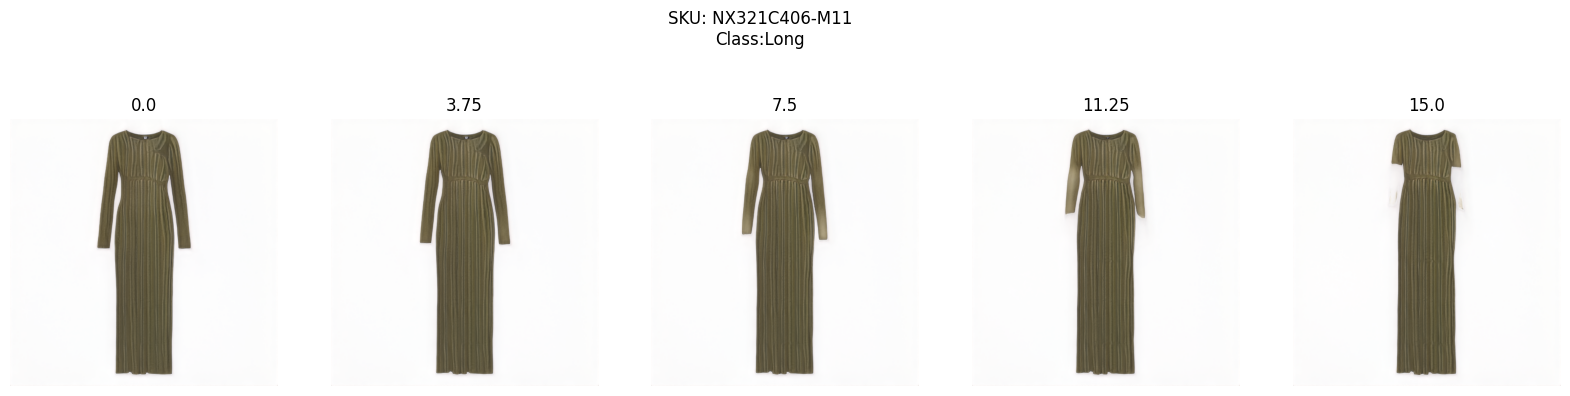

In [20]:
# Sample one latent
sample = df.sample(1)
latent_code = latents[sample.sku.item()]

steps = 5
distance = 15

if sample.label.item() == 0: 
    start_distance, end_distance = 0, distance
elif sample.label.item() == 1: 
    start_distance, end_distance = -distance,  0
dims_to_change = [0, 1]

interpolations = get_interpolations_multiple(latent_code, start_distance, end_distance, steps, dims_to_change)

imgs = [generate_from_latent(interpolations[i, :, :].unsqueeze(0)) for i in range(steps)]
fig, ax = plt.subplots(1, steps, figsize=(20, 5))
ax = ax.ravel()
for i in range(steps):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
    ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")

fig.suptitle(f"SKU: {sample.sku.item()}\nClass:{sample[attribute].item()}")
plt.show()

### Test Directions with PTI Generator

In [14]:
sku = 'SOA21C0KG-J11'
#sku = "02R21C014-Q11"


In [15]:
device = torch.device('cpu')


os.chdir(f"{ROOT_PATH}/2_Inversion/PTI/")
from pti_utils import load_pti
os.chdir(current_wd)


G_PTI, latent = load_pti(sku)

# Freeze and set to eval
G_PTI.eval()
for param in G_PTI.parameters():
    param.requires_grad = False

# Send to CPU
G_PTI = G_PTI.to(device)
latent_pti = latent.to(device)

Using mps as device


In [16]:
def generate_pti(latent):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    img = tensor2im(gen.squeeze(0))
    return img

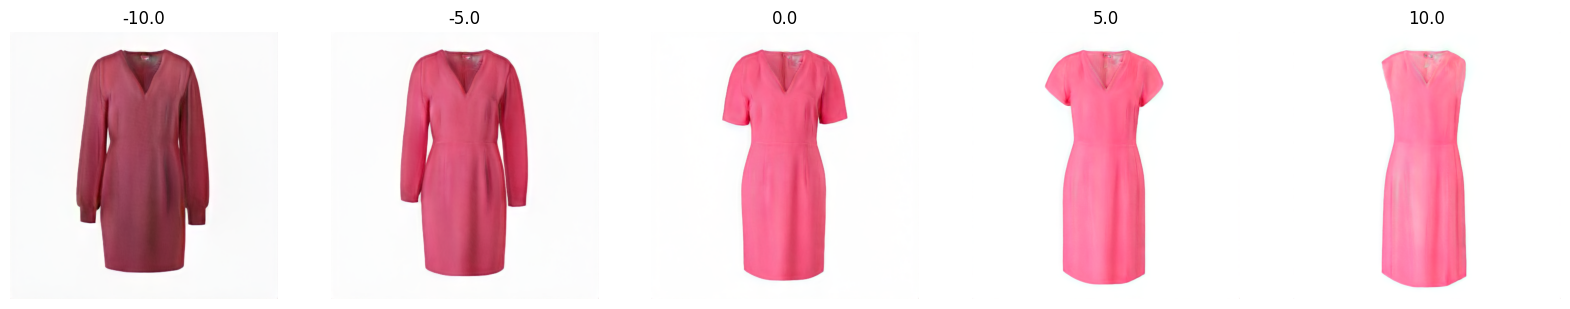

In [17]:
steps = 5
start_distance = -10
end_distance = 10
dims_to_change = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

interpolations = get_interpolations_multiple(latent_pti, start_distance, end_distance, steps, dims_to_change)

imgs = [generate_pti(interpolations[i, :, :].unsqueeze(0)) for i in range(steps)]
fig, ax = plt.subplots(1, steps, figsize=(20, 5))
ax = ax.ravel()
for i in range(steps):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
    ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")

plt.show()